## 1. Tidy-up Transformations
Import the .onnx model and apply standard transformations to remove unnecessary information and make the model cleaner and simpler.

In [2]:
import onnx
import brevitas.onnx as bo
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron

build_dir = './output_test'

# Run tidy-up transformations on model

model = ModelWrapper(build_dir + "/finn_lenet.onnx")
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + "/finn_lenet_tidy.onnx")

/home/rstar900/finn/deps/qonnx/src/qonnx/core/modelwrapper.py:93: UserWarning: Some old-style domain attributes were automatically converted to new-style,
                i.e. domain=finn to domain=qonnx.custom_op.<general|fpgadataflow|...>
  warnings.warn(


In [6]:
# Visualize the original onnx export
showInNetron(build_dir+"/finn_lenet.onnx")

Serving './output_test/finn_lenet.onnx' at http://0.0.0.0:8081


In [3]:
# Visualize the tidy-up version (Multithreshold layer is responsible for quantizing inputs to 8-bit INT)

showInNetron(build_dir+"/finn_lenet_tidy.onnx")

Serving './output_test/finn_lenet_tidy.onnx' at http://0.0.0.0:8081


## 2. Pre and Post Processing 
Adding FINN's primitives for toTensor (divide input by 255) and Top-K (to select the class number with the highest probability)

In [8]:
# Adding Pre-processing 
# (We have to do quantization ourselves, The initial multithreshold does not convert to hardware on its own)

from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

model = ModelWrapper(build_dir+"/finn_lenet_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+"/finn_lenet_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

/home/rstar900/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:119: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [9]:
# Adding post-processing (Top K)
# This will basically output the class with the highest probability as 8-bit INT instead of a float32 array 

from qonnx.transformation.insert_topk import InsertTopK
from qonnx.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+"/finn_lenet_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

In [4]:
# Visualize the model with pre and post processing
showInNetron(build_dir+"/finn_lenet_pre_post.onnx")

Stopping http://0.0.0.0:8081
Serving './output_test/finn_lenet_pre_post.onnx' at http://0.0.0.0:8081


## 3. Streamlining Transformations

In [11]:
# Applying streamlining transformations

from finn.transformation.streamline import Streamline
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
#from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = ModelWrapper(build_dir + "/finn_lenet_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
# model = model.transform(ConvertBipolarMatMulToXnorPopcount()) # probably not needed due to this not being a BNN
model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + "/finn_lenet_streamlined.onnx")

In [5]:
# Visualize streamlined model
# Conv layers turned into Im2Col, MatMul pairs and some others have changed to MultiThreshold

showInNetron(build_dir+"/finn_lenet_streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving './output_test/finn_lenet_streamlined.onnx' at http://0.0.0.0:8081


## 4. Partitioning and conversion to HLS Layers 

In [14]:
# Partitioning and conversion to HLS Layers 

import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.infer_data_layouts import InferDataLayouts

# choose the memory mode for the MVTU units, decoupled or const
mem_mode = "decoupled"

model = ModelWrapper(build_dir + "/finn_lenet_streamlined.onnx")
model = model.transform(to_hls.InferBinaryMatrixVectorActivation(mem_mode))
model = model.transform(to_hls.InferQuantizedMatrixVectorActivation(mem_mode))
# TopK to LabelSelect
model = model.transform(to_hls.InferLabelSelectLayer())
# input quantization (if any) to standalone thresholding
model = model.transform(to_hls.InferThresholdingLayer())
model = model.transform(to_hls.InferConvInpGen())
model = model.transform(to_hls.InferStreamingMaxPool())
# get rid of Reshape(-1, 1) operation between hlslib nodes
model = model.transform(RemoveCNVtoFCFlatten())
# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())
# infer tensor data layouts
model = model.transform(InferDataLayouts())

## DEBUGGING TRANSFORMATIONS (These solved the issue by converting layers which were not converted to HLS ones)
## https://github.com/Xilinx/finn/discussions/431
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbConsecutiveTransposes())
model = model.transform(to_hls.InferStreamingMaxPool())
model = model.transform(RemoveCNVtoFCFlatten())
model.save(build_dir + "/finn_lenet_before_dataflow.onnx");
## DEBUGGING SAVE (Solved the issue by above block)

parent_model = model.transform(CreateDataflowPartition()) # solved error here
parent_model.save(build_dir + "/finn_lenet_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# save the dataflow partition with a different name for easier access
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model.save(build_dir + "/finn_lenet_dataflow_model.onnx")

In [9]:
# Check the model just before error (Solved)
# showInNetron(build_dir+"/finn_lenet_before_dataflow.onnx")

Notice the additional RemoveCNVtoFCFlatten transformation that was not used for TFC-w1a1. In the last Netron visualization you may have noticed a Reshape operation towards the end of the network where the convolutional part of the network ends and the fully-connected layers started. That Reshape is essentialy a tensor flattening operation, which we can remove for the purposes of hardware implementation. We can examine the contents of the dataflow partition with Netron, and observe the ConvolutionInputGenerator, MatrixVectorActivation and StreamingMaxPool_Batch nodes that implement the sliding window, matrix multiply and maxpool operations in hlslib. Note that the MatrixVectorActivation instances following the ConvolutionInputGenerator nodes are really implementing the convolutions, despite the name. The final three MatrixVectorActivation instances implement actual FC layers.

In [15]:
showInNetron(build_dir + "/finn_lenet_dataflow_parent.onnx")

Stopping http://0.0.0.0:8081
Serving './output_test/finn_lenet_dataflow_parent.onnx' at http://0.0.0.0:8081


Note that pretty much everything has gone into the StreamingDataflowPartition node; the only operation remaining is to apply a Transpose to obtain NHWC input from a NCHW input (the ONNX default).

In [16]:
# This is the StreamingDataflowPartition visualized
showInNetron(build_dir + "/finn_lenet_dataflow_model.onnx")

Stopping http://0.0.0.0:8081
Serving './output_test/finn_lenet_dataflow_model.onnx' at http://0.0.0.0:8081


In [17]:
# Leaving folding for now (using defaults by FINN of PE = 1 and SIMD = 1 which is maximum folding)
model = ModelWrapper(build_dir + "/finn_lenet_dataflow_model.onnx")
# Folding can happen below
# Folding can happen above
model = model.transform(GiveUniqueNodeNames())
model.save(build_dir + "/finn_lenet_folded.onnx")

In [13]:
# Visualize the folded version
showInNetron(build_dir + "/finn_lenet_folded.onnx")

Stopping http://0.0.0.0:8081
Serving './output_test/finn_lenet_folded.onnx' at http://0.0.0.0:8081


## 5. Hardware Generation

In [14]:
# Hardware Generation

# Check numpy version (should be 1.22.0)
! pip freeze | grep numpy

numpy==1.24.1


In [15]:
# if it is not, then run this cell
! pip uninstall numpy -y
! pip install numpy==1.22.0

Found existing installation: numpy 1.24.1
Uninstalling numpy-1.24.1:
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/shutil.py", line 788, in move
    os.rename(src, real_dst)
PermissionError: [Errno 13] Permission denied: '/opt/conda/bin/f2py' -> '/tmp/pip-uninstall-orijhy_7/f2py'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 228, in _main
    status = self.run(options, args)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/commands/uninstall.py", line 89, in run
    uninstall_pathset = req.uninstall(
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/req/req_install.py", line 686, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/req/req_uninstall.py", line 394, in remove
    moved.stash(path)
  File "/o

In [16]:
# Modify the basic.py file to add part number for Ultra96-V2 board

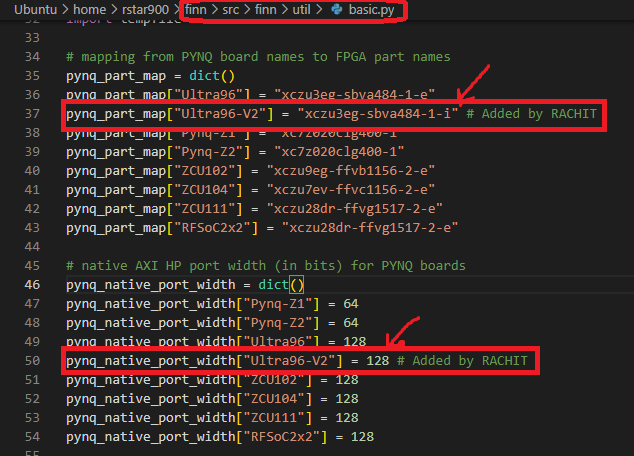

In [17]:
# Modified templates.py to add support for Ultra96-V2 board

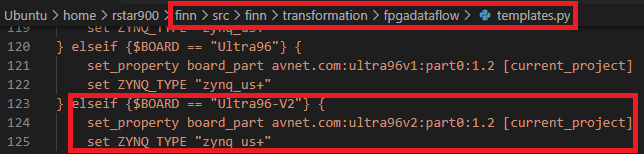

In [18]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = build_dir + "/finn_lenet_folded.onnx"

final_output_dir = build_dir + "_deploy"

#Delete previous run results if exist
if os.path.exists(final_output_dir):
    shutil.rmtree(final_output_dir)
    print("Previous run results deleted!")

cfg = build.DataflowBuildConfig(
    output_dir          = final_output_dir,
    mvau_wwidth_max     = 12, #80 was the original but wanted to constrain owidth to multiple of 12 as iwidth = 12
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    board               = "Ultra96-V2", # See the modifications done above
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.BITFILE,
        build_cfg.DataflowOutputType.PYNQ_DRIVER,
        build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ]
)

Previous run results deleted!


In [19]:
%%time
build.build_dataflow_cfg(model_file, cfg)

Building dataflow accelerator from ./output_test/finn_lenet_folded.onnx
Intermediate outputs will be generated in /home/rstar900/finn/my_builds
Final outputs will be generated in ./output_test_deploy
Build log is at ./output_test_deploy/build_dataflow.log
Running step: step_qonnx_to_finn [1/17]
Running step: step_tidy_up [2/17]
Running step: step_streamline [3/17]
Running step: step_convert_to_hls [4/17]
Running step: step_create_dataflow_partition [5/17]
Running step: step_target_fps_parallelization [6/17]
Running step: step_apply_folding_config [7/17]
Running step: step_generate_estimate_reports [8/17]
Running step: step_hls_codegen [9/17]
Running step: step_hls_ipgen [10/17]
Running step: step_set_fifo_depths [11/17]
Running step: step_create_stitched_ip [12/17]
Running step: step_measure_rtlsim_performance [13/17]
Running step: step_out_of_context_synthesis [14/17]
Running step: step_synthesize_bitfile [15/17]
Running step: step_make_pynq_driver [16/17]
Running step: step_deploymen

0

In [22]:
# Now compress the deploy folder and send to Pynq board 
from shutil import make_archive
final_output_dir = build_dir + "_deploy"
make_archive('deploy-on-pynq', 'zip', final_output_dir+"/deploy")
# scp from terminal after this step
# scp ./deploy-on-pynq.zip  xilinx@192.168.3.1:/home/xilinx/

'/home/rstar900/finn/notebooks/deploy-on-pynq.zip'